### An evolutionary algorithm to optimize the ResNet-18 architecture using CIFAR-10.

---

#### **Key Components**

#### **Genome Representation**
Each architecture is represented by a dictionary containing:
- Number of blocks in each layer
- Base channel size

The `ModelGenome` class stores:
- Architecture
- Fitness score
- Corresponding model

#### **Evolutionary Process**
1. **Initialization:**
   - Random initialization of architectures within the defined search space.
   - Creates a population of diverse ResNet variants.

2. **Selection:**
   - Tournament selection to choose parents.
   - Elitism to preserve the best individual in each generation.

3. **Crossover:**
   - Uniform crossover combines architectural parameters from two parents.

4. **Mutation:**
   - Random modifications to architectural parameters.
   - Mutation rate adjusts adaptively to prevent stagnation.

5. **Evaluation:**
   - Trains each model for a few epochs using validation accuracy as the fitness metric.
   - Implements early stopping for efficiency.

Files already downloaded and verified
Files already downloaded and verified

Evaluating initial individual 1/8
Epoch 1: Train Acc: 41.67% | Val Acc: 49.83%
Epoch 2: Train Acc: 56.09% | Val Acc: 59.78%
Epoch 3: Train Acc: 63.25% | Val Acc: 62.41%
Epoch 4: Train Acc: 67.61% | Val Acc: 66.32%
Epoch 5: Train Acc: 70.19% | Val Acc: 67.45%

Evaluating initial individual 2/8
Epoch 1: Train Acc: 38.71% | Val Acc: 45.49%
Epoch 2: Train Acc: 55.31% | Val Acc: 57.51%
Epoch 3: Train Acc: 64.59% | Val Acc: 59.64%
Epoch 4: Train Acc: 72.06% | Val Acc: 65.16%
Epoch 5: Train Acc: 77.11% | Val Acc: 67.48%

Evaluating initial individual 3/8
Epoch 1: Train Acc: 41.28% | Val Acc: 52.43%
Epoch 2: Train Acc: 57.65% | Val Acc: 59.57%
Epoch 3: Train Acc: 66.92% | Val Acc: 64.13%
Epoch 4: Train Acc: 73.77% | Val Acc: 66.96%
Epoch 5: Train Acc: 78.23% | Val Acc: 68.26%

Evaluating initial individual 4/8
Epoch 1: Train Acc: 41.59% | Val Acc: 49.82%
Epoch 2: Train Acc: 56.47% | Val Acc: 59.11%
Epoch 3: Train Acc:

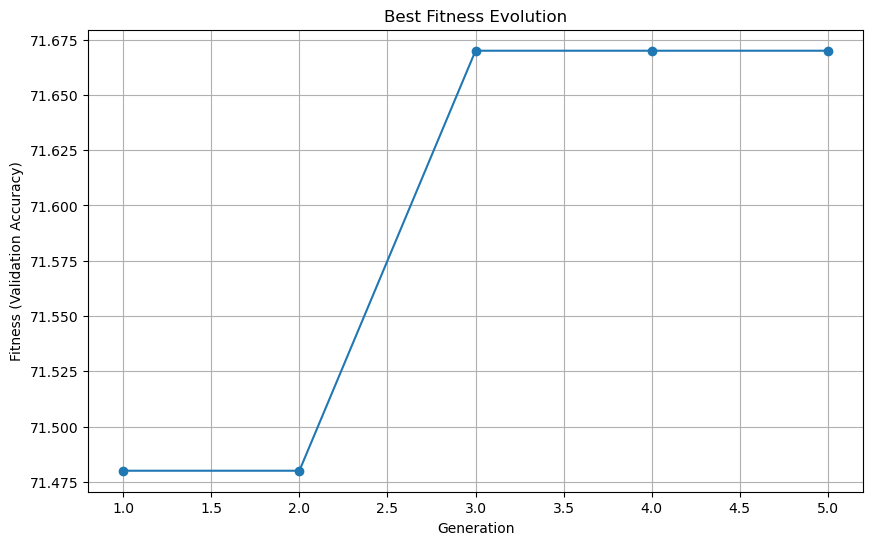

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import random
import numpy as np
from typing import List, Tuple, Dict
from dataclasses import dataclass
from torch.utils.data import Subset
import matplotlib.pyplot as plt

@dataclass
class ModelGenome:
    """Represents a single model in the population"""
    architecture: Dict[str, int] # layer sizes, number of blocks etc.
    fitness: float = 0.0
    model: nn.Module = None

class CustomBlock(nn.Module):
    """Custom ResNet block with correct channel handling"""
    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class CustomResNet(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.base_channels = architecture['base_channels']
        
        # Initial layer
        self.conv1 = nn.Conv2d(3, self.base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.base_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Main layers
        self.layer1 = self._make_layer(self.base_channels, architecture['layer1_blocks'], stride=1)
        self.layer2 = self._make_layer(self.base_channels * 2, architecture['layer2_blocks'], stride=2)
        self.layer3 = self._make_layer(self.base_channels * 4, architecture['layer3_blocks'], stride=2)
        self.layer4 = self._make_layer(self.base_channels * 8, architecture['layer4_blocks'], stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(self.base_channels * 8, 10)  # 10 classes for CIFAR-10

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, planes, blocks, stride):
        layers = []
        inplanes = planes if stride == 1 else planes // 2
        
        # First block handles stride and channel change
        layers.append(CustomBlock(inplanes, planes, stride))
        
        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(CustomBlock(planes, planes))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
    
class EvolutionaryResNet:
    def __init__(
        self,
        population_size: int = 8,  # Increased population size
        mutation_rate: float = 0.3,  # Increased mutation rate
        num_generations: int = 5,
        tournament_size: int = 3
    ):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_generations = num_generations
        self.tournament_size = tournament_size
        self.population = []
        
        # Expanded search space
        self.search_space = {
            'layer1_blocks': (1, 3),
            'layer2_blocks': (1, 3),
            'layer3_blocks': (1, 3),
            'layer4_blocks': (1, 3),
            'base_channels': [32, 48, 64],  # Added intermediate option
        }
        
        # Track best model and fitness
        self.best_fitness = 0
        self.generations_without_improvement = 0

    def initialize_population(self) -> None:
        """Initialize population with increased diversity"""
        # Ensure at least one of each extreme configuration
        min_config = {
            'layer1_blocks': self.search_space['layer1_blocks'][0],
            'layer2_blocks': self.search_space['layer2_blocks'][0],
            'layer3_blocks': self.search_space['layer3_blocks'][0],
            'layer4_blocks': self.search_space['layer4_blocks'][0],
            'base_channels': min(self.search_space['base_channels'])
        }
        max_config = {
            'layer1_blocks': self.search_space['layer1_blocks'][1],
            'layer2_blocks': self.search_space['layer2_blocks'][1],
            'layer3_blocks': self.search_space['layer3_blocks'][1],
            'layer4_blocks': self.search_space['layer4_blocks'][1],
            'base_channels': max(self.search_space['base_channels'])
        }
        
        self.population.append(ModelGenome(architecture=min_config))
        self.population.append(ModelGenome(architecture=max_config))
        
        # Random configurations for the rest
        while len(self.population) < self.population_size:
            architecture = {
                'layer1_blocks': random.randint(*self.search_space['layer1_blocks']),
                'layer2_blocks': random.randint(*self.search_space['layer2_blocks']),
                'layer3_blocks': random.randint(*self.search_space['layer3_blocks']),
                'layer4_blocks': random.randint(*self.search_space['layer4_blocks']),
                'base_channels': random.choice(self.search_space['base_channels'])
            }
            # Ensure diversity by checking if this architecture is unique
            if not any(self.architectures_equal(architecture, genome.architecture) 
                      for genome in self.population):
                self.population.append(ModelGenome(architecture=architecture))

    def architectures_equal(self, arch1, arch2):
        """Compare two architectures for equality"""
        return all(arch1[key] == arch2[key] for key in arch1.keys())

    def create_model(self, architecture: Dict) -> nn.Module:
        return CustomResNet(architecture)
    
    def crossover(self, parent1: ModelGenome, parent2: ModelGenome) -> ModelGenome:
        """Create child architecture by combining parents"""
        child_architecture = {}
        for key in parent1.architecture.keys():
            if random.random() < 0.5:
                child_architecture[key] = parent1.architecture[key]
            else:
                child_architecture[key] = parent2.architecture[key]
        return ModelGenome(architecture=child_architecture)
    
    def evaluate_model(self, model: nn.Module, train_loader, val_loader, 
                      epochs: int = 5) -> float:  # Increased epochs slightly
        device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        
        # Use SGD with momentum instead of Adam
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        
        # Add learning rate scheduler
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
        
        best_acc = 0.0
        patience = 2  # Early stopping patience
        no_improve = 0
        
        for epoch in range(epochs):
            # Training with progress tracking
            model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            train_acc = 100. * correct / total
            
            # Validation
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            
            acc = 100. * correct / total
            
            # Early stopping check
            if acc > best_acc:
                best_acc = acc
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
            
            scheduler.step()
            
            print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.2f}% | Val Acc: {acc:.2f}%")
        
        return best_acc

    def mutate(self, genome: ModelGenome) -> None:
        """Enhanced mutation with adaptive rates"""
        # Increase mutation rate if fitness is stagnating
        current_mutation_rate = self.mutation_rate * (1 + 0.1 * self.generations_without_improvement)
        
        for key in genome.architecture:
            if random.random() < current_mutation_rate:
                if key == 'base_channels':
                    # Prefer adjacent values in the list
                    current_idx = self.search_space['base_channels'].index(genome.architecture[key])
                    possible_idx = [i for i in range(len(self.search_space['base_channels']))
                                  if abs(i - current_idx) <= 1]
                    genome.architecture[key] = self.search_space['base_channels'][random.choice(possible_idx)]
                else:
                    # For block numbers, prefer small changes
                    current_val = genome.architecture[key]
                    min_val, max_val = self.search_space[key]
                    change = random.choice([-1, 1])
                    genome.architecture[key] = max(min_val, min(max_val, current_val + change))

    def tournament_selection(self) -> ModelGenome:
        """Select parent using tournament selection"""
        tournament = random.sample(self.population, self.tournament_size)
        return max(tournament, key=lambda x: x.fitness)
    
    def evolve(self, train_loader, val_loader) -> Tuple[ModelGenome, List[float]]:
        self.initialize_population()
        best_fitness_history = []
        best_genome = None
        
        # Evaluate initial population
        for i, genome in enumerate(self.population):
            print(f"\nEvaluating initial individual {i + 1}/{self.population_size}")
            model = self.create_model(genome.architecture)
            genome.fitness = self.evaluate_model(model, train_loader, val_loader)
            genome.model = model
            
            if genome.fitness > self.best_fitness:
                self.best_fitness = genome.fitness
                self.generations_without_improvement = 0
            else:
                self.generations_without_improvement += 1
        
        for generation in range(self.num_generations):
            print(f"\nGeneration {generation + 1}/{self.num_generations}")
            new_population = []
            
            # Elitism: keep top 2 individuals
            sorted_population = sorted(self.population, key=lambda x: x.fitness, reverse=True)
            new_population.extend(copy.deepcopy(sorted_population[:2]))
            
            # Create rest of new population
            while len(new_population) < self.population_size:
                # Tournament selection with increased pressure
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()
                
                if random.random() < 0.8:  # 80% chance of crossover
                    child = self.crossover(parent1, parent2)
                else:  # Otherwise, clone better parent
                    child = copy.deepcopy(max(parent1, parent2, key=lambda x: x.fitness))
                
                self.mutate(child)
                
                # Only evaluate if architecture is unique
                if not any(self.architectures_equal(child.architecture, genome.architecture) 
                          for genome in new_population):
                    print(f"\nEvaluating new individual {len(new_population) + 1}/{self.population_size}")
                    model = self.create_model(child.architecture)
                    child.fitness = self.evaluate_model(model, train_loader, val_loader)
                    child.model = model
                    new_population.append(child)
            
            self.population = new_population
            generation_best = max(self.population, key=lambda x: x.fitness)
            best_fitness_history.append(generation_best.fitness)
            
            # Update best genome and check for improvement
            if best_genome is None or generation_best.fitness > best_genome.fitness:
                best_genome = copy.deepcopy(generation_best)
                self.best_fitness = generation_best.fitness
                self.generations_without_improvement = 0
            else:
                self.generations_without_improvement += 1
            
            print(f"Generation Best Fitness: {generation_best.fitness:.2f}")
            print(f"Generations without improvement: {self.generations_without_improvement}")
        
        return best_genome, best_fitness_history


def plot_fitness_history(fitness_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(fitness_history) + 1), fitness_history, marker='o')
    plt.title('Best Fitness Evolution')
    plt.xlabel('Generation')
    plt.ylabel('Fitness (Validation Accuracy)')
    plt.grid(True)
    plt.show()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
    
    # Create small subset for quick demo
    # train_subset = Subset(trainset, range(40000))
    train_subset = trainset
    # test_subset = Subset(testset, range(10000))
    test_subset = testset
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64,
                                             shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64,
                                            shuffle=False, num_workers=2)
    
    # Initialize and run evolution
    evolution = EvolutionaryResNet()
    best_genome, fitness_history = evolution.evolve(train_loader, test_loader)
    
    print("\nBest Architecture Found:")
    for key, value in best_genome.architecture.items():
        print(f"{key}: {value}")
    print(f"Best Fitness: {best_genome.fitness:.2f}")
    
    # Plot fitness history
    plot_fitness_history(fitness_history)
    
    # Save the best model
    torch.save(best_genome.model.state_dict(), 'best_evolved_resnet.pth')

if __name__ == "__main__":
    main()